## LOO-PIT, K-hat and ELPD difference plots - Examples of obsolete and current protein structures

In the following plots, the leftmost panel corresponds to the oldest/obsolete structure. Middle and right panel correspond to current or crystallographic structures for the same protein. For the ELPD difference plots, sequence alignment was perfomed when needed using non general heuristics.

In [1]:
%load_ext watermark
import matplotlib.pyplot as plt
import arviz as az
import os
import pandas as pd
import numpy as np

from hierarchical_bayes_nmr_validation import *

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = "2KWM"
protein2 = '2LML'
bmrb_code = '16860'
samples = 2000

In [4]:
# CS data is collected for every protein in a single dataframe
dataframe_protein_1 = get_biomolecular_data(protein1, bmrb_code)
dataframe_protein_2 = get_biomolecular_data(protein2, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)
/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [8]:
# run hierarchical bayesian linear regression for each protein 
if f'idata_{protein1}.nc' in os.listdir('./data/'):
    idata_protein_1 = az.from_netcdf(f'data/idata_{protein1}.nc')
else:
    dataframe_reference_protein_1, idata_reference_protein_1 = hierarchical_reg_reference(target_df=dataframe_protein_1, samples=2000)
    idata_protein_1 = idata_reference_protein_1.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_1.shape[0]-dataframe_protein_1.shape[0], dataframe_reference_protein_1.shape[0]))
    az.to_netcdf(idata_protein_1, f"data/idata_{protein1}.nc")

In [9]:
if f'idata_{protein2}.nc' in os.listdir('./data/'):
    idata_protein_2 = az.from_netcdf(f'data/idata_{protein2}.nc')
else:
    dataframe_reference_protein_2, idata_reference_protein_2 = hierarchical_reg_reference(target_df=dataframe_protein_2, samples=2000)
    idata_protein_2 = idata_reference_protein_2.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_2.shape[0]-dataframe_protein_2.shape[0], dataframe_reference_protein_2.shape[0]))
    az.to_netcdf(idata_protein_2, f"data/idata_{protein2}.nc")

# LOO

<ipython-input-10-1c49bb78bea1>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


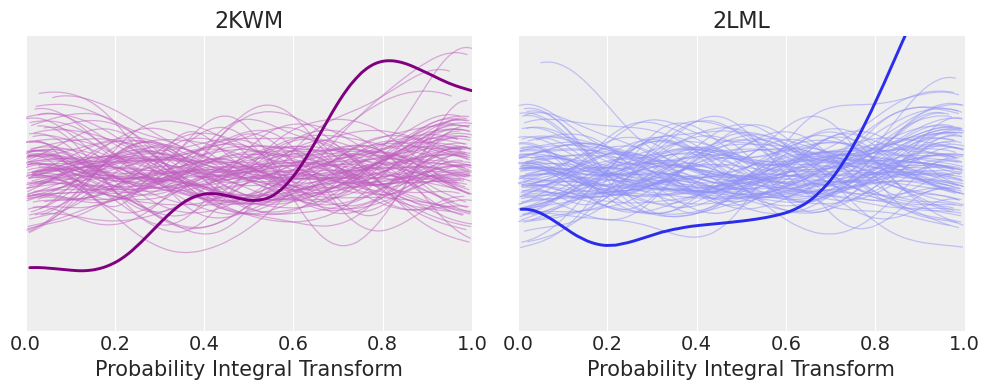

In [10]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_protein_1, y="cheshift", legend=False, ax=ax[0], color='purple')
az.plot_loo_pit(idata_protein_2, y="cheshift", legend=False, ax=ax[1])
ax[0].set_title(protein1)
ax[1].set_title(protein2)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_loo_pit.png", dpi=300)

# Khat

In [11]:
# compute LOO separately
loo_protein_1 = az.loo(idata_protein_1, pointwise=True)
loo_protein_2 = az.loo(idata_protein_2, pointwise=True)

<ipython-input-14-d421ebd23171>:12: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


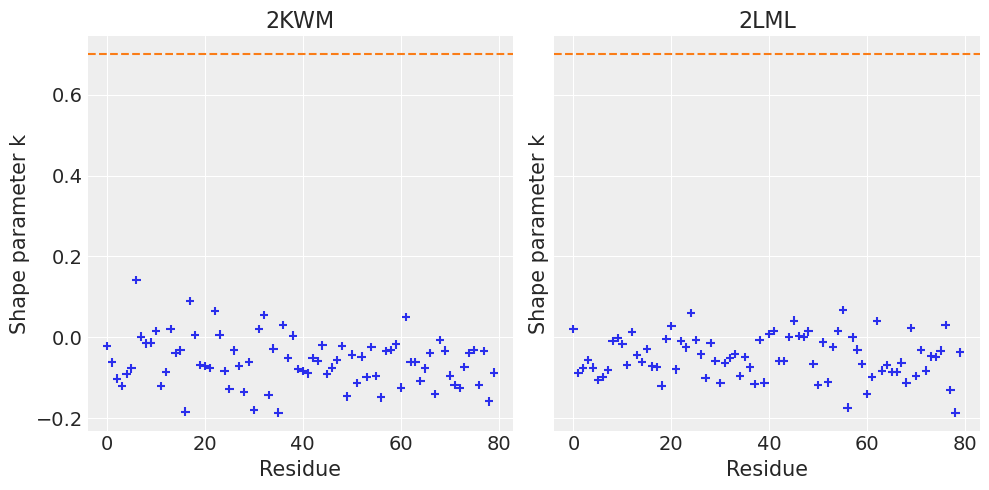

In [14]:
# Plot K-hat
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

az.plot_khat(loo_protein_1, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_protein_2, hlines_kwargs={"alpha":0}, ax=ax[1])

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
[ax[i].set_title(protein) for i, protein in enumerate([protein1, protein2])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_khat.png", dpi=300)

# ELPD

In [15]:
# compute ELPD difference
loo_protein_1 = az.loo(idata_protein_1, pointwise=True).loo_i.values
loo_protein_2 = az.loo(idata_protein_2, pointwise=True).loo_i.values
loo_protein_1.shape, loo_protein_2.shape

((80,), (80,))

In [16]:
elpd = loo_protein_1 - loo_protein_2

/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/elpdplot.py:106: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.autofmt_xdate()


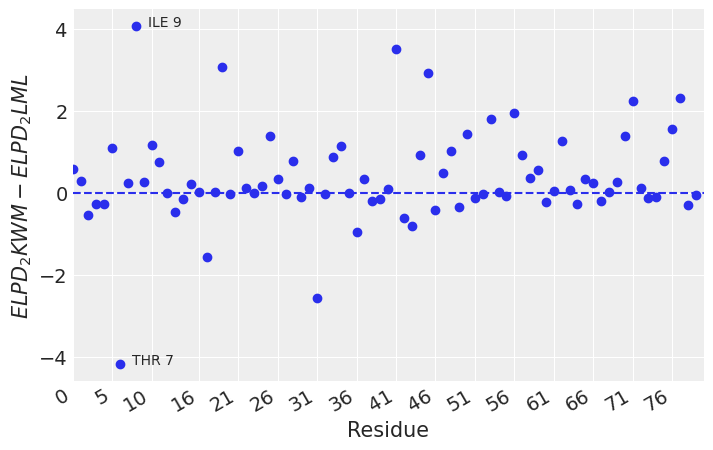

In [17]:
# plot ELPD difference
ax = az.plot_elpd({f"{protein1}": idata_protein_1, f"{protein2}": idata_protein_2}, xlabels=True)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel(f'$ELPD_{protein1}-ELPD_{protein2}$')
ax.set_xlim(1, len(dataframe_protein_1))
ax.set_xticks(dataframe_protein_1.index[::5])
ax.set_xticklabels([str(n) for n in dataframe_protein_1.index[::5]])
ax.set_title('')
da_1 = dataframe_protein_1.res[elpd > 4]
da_2 = dataframe_protein_1.res[elpd < -4]
da = pd.concat([da_1, da_2])
xs = da.index.values+1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text, xs, ys):
    ax.annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight", dpi=300);

In [18]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = "1M4O"
protein2 = '1ZRR'
bmrb_code = '4313'
samples = 2000

In [19]:
# CS data is collected for every protein in a single dataframe
dataframe_protein_1 = get_biomolecular_data(protein1, bmrb_code)
dataframe_protein_2 = get_biomolecular_data(protein2, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)
/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [20]:
# run hierarchical bayesian linear regression for each protein 
if f'idata_{protein1}.nc' in os.listdir('./data/'):
    idata_protein_1 = az.from_netcdf(f'data/idata_{protein1}.nc')
else:
    dataframe_reference_protein_1, idata_reference_protein_1 = hierarchical_reg_reference(target_df=dataframe_protein_1, samples=2000)
    idata_protein_1 = idata_reference_protein_1.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_1.shape[0]-dataframe_protein_1.shape[0], dataframe_reference_protein_1.shape[0]))
    az.to_netcdf(idata_protein_1, f"data/idata_{protein1}.nc")

In [21]:
if f'idata_{protein2}.nc' in os.listdir('./data/'):
    idata_protein_2 = az.from_netcdf(f'data/idata_{protein2}.nc')
else:
    dataframe_reference_protein_2, idata_reference_protein_2 = hierarchical_reg_reference(target_df=dataframe_protein_2, samples=2000)
    idata_protein_2 = idata_reference_protein_2.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_2.shape[0]-dataframe_protein_2.shape[0], dataframe_reference_protein_2.shape[0]))
    az.to_netcdf(idata_protein_2, f"data/idata_{protein2}.nc")

# LOO

<ipython-input-22-1c49bb78bea1>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


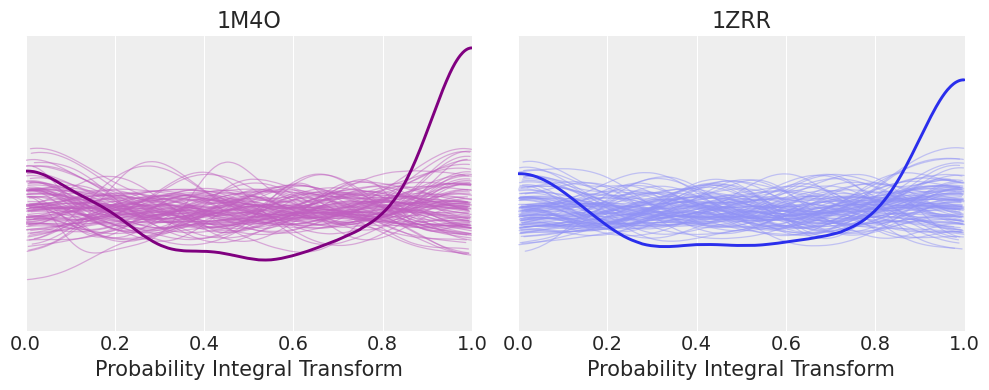

In [22]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_protein_1, y="cheshift", legend=False, ax=ax[0], color='purple')
az.plot_loo_pit(idata_protein_2, y="cheshift", legend=False, ax=ax[1])
ax[0].set_title(protein1)
ax[1].set_title(protein2)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_loo_pit.png", dpi=300)

# Khat

In [23]:
# compute LOO separately
loo_protein_1 = az.loo(idata_protein_1, pointwise=True)
loo_protein_2 = az.loo(idata_protein_2, pointwise=True)

<ipython-input-24-013b9bd66264>:15: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


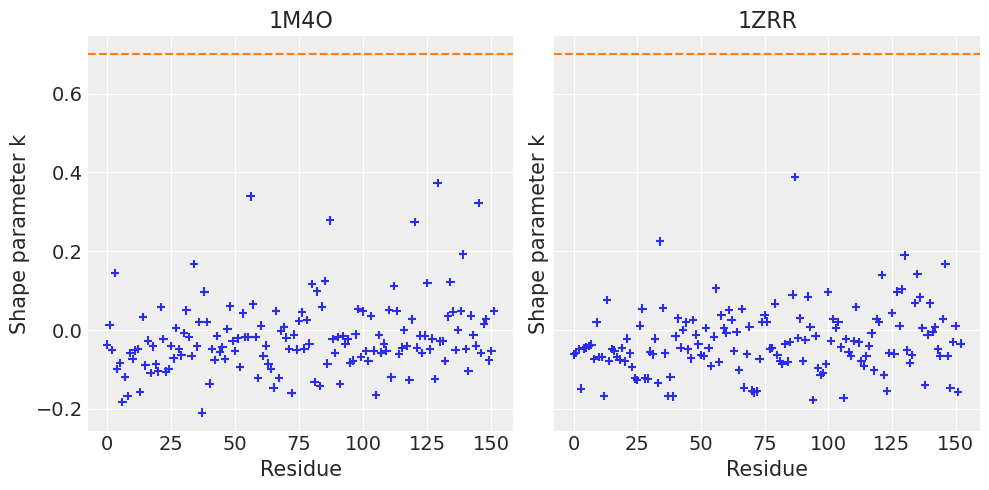

In [24]:
# Plot K-hat
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

az.plot_khat(loo_protein_1, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_protein_2, hlines_kwargs={"alpha":0}, ax=ax[1])

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
# [ax[i].set_xticks([-1, 8, 18, 28, 38, 48, 58, 68]) for i in range(len(ax))]
# [ax[i].set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70']) for i in range(len(ax))]

[ax[i].set_title(protein) for i, protein in enumerate([protein1, protein2])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_khat.png", dpi=300)

# ELPD

In [61]:
# compute ELPD difference
loo_protein_1 = az.loo(idata_protein_1, pointwise=True).loo_i.values
loo_protein_2 = az.loo(idata_protein_2, pointwise=True).loo_i.values
loo_protein_1.shape, loo_protein_2.shape

((152,), (153,))

In [62]:
dataframe_protein_1.res.values[104]

'GLU'

In [63]:
dataframe_protein_2.res.values[104]

'ASP'

In [64]:
loo_protein_2 = np.delete(loo_protein_2, 104)

In [65]:
elpd = loo_protein_1 - loo_protein_2

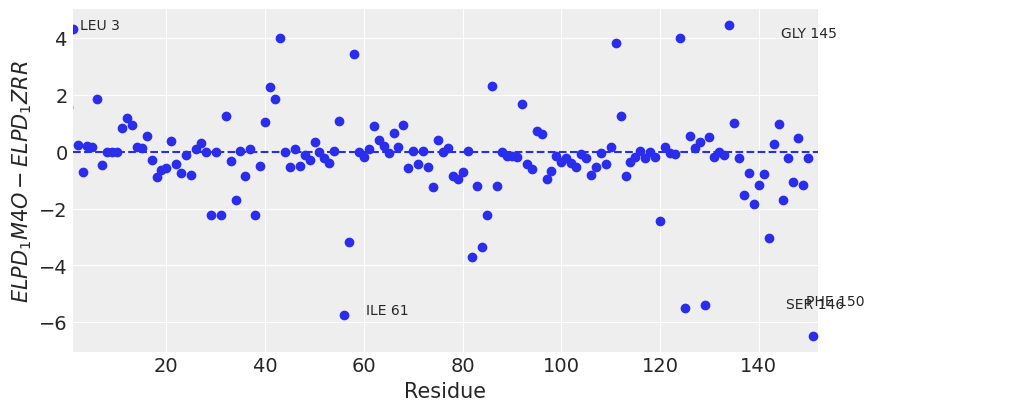

In [70]:
# plot ELPD difference
_, ax = plt.subplots(figsize=(10, 4))
ax.scatter(range(len(elpd)), elpd)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel(f'$ELPD_{protein1}-ELPD_{protein2}$')
ax.set_xlim(1, len(dataframe_protein_1))
ax.set_title('')
da_1 = dataframe_protein_1.res[elpd > 4]
da_2 = dataframe_protein_1.res[elpd < -4]
da = pd.concat([da_1, da_2])
xs = da.index.values+1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text, xs, ys):
    ax.annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight", dpi=300);

In [71]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = "1YWZ"
protein2 = '2K07'
protein3 = '2Z6O' #crystal struture
bmrb_code = '6546'
samples = 2000

In [72]:
# CS data is collected for every protein in a single dataframe
dataframe_protein_1 = get_biomolecular_data(protein1, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [73]:
dataframe_protein_2 = get_biomolecular_data(protein2, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [74]:
dataframe_protein_3 = get_biomolecular_data(protein3, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [75]:
# run hierarchical bayesian linear regression for each protein 
if f'idata_{protein1}.nc' in os.listdir('./data/'):
    idata_protein_1 = az.from_netcdf(f'data/idata_{protein1}.nc')
else:
    dataframe_reference_protein_1, idata_reference_protein_1 = hierarchical_reg_reference(target_df=dataframe_protein_1, samples=2000)
    idata_protein_1 = idata_reference_protein_1.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_1.shape[0]-dataframe_protein_1.shape[0], dataframe_reference_protein_1.shape[0]))
    az.to_netcdf(idata_protein_1, f"data/idata_{protein1}.nc")

In [84]:
if f'idata_{protein2}.nc' in os.listdir('./data/'):
    idata_protein_2 = az.from_netcdf(f'data/idata_{protein2}.nc')
else:
    dataframe_reference_protein_2, idata_reference_protein_2 = hierarchical_reg_reference(target_df=dataframe_protein_2, samples=2000)
    idata_protein_2 = idata_reference_protein_2.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_2.shape[0]-dataframe_protein_2.shape[0], dataframe_reference_protein_2.shape[0]))
    az.to_netcdf(idata_protein_2, f"data/idata_{protein2}.nc")

In [85]:
if f'idata_{protein3}.nc' in os.listdir('./data/'):
    idata_protein_3 = az.from_netcdf(f'data/idata_{protein3}.nc')
else:
    dataframe_reference_protein_3, idata_reference_protein_3 = hierarchical_reg_reference(target_df=dataframe_protein_3, samples=2000)
    idata_protein_3 = idata_reference_protein_3.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_3.shape[0]-dataframe_protein_3.shape[0], dataframe_reference_protein_3.shape[0]))
    az.to_netcdf(idata_protein_3, f"data/idata_{protein3}.nc")

# LOO

<ipython-input-86-752a75692290>:11: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


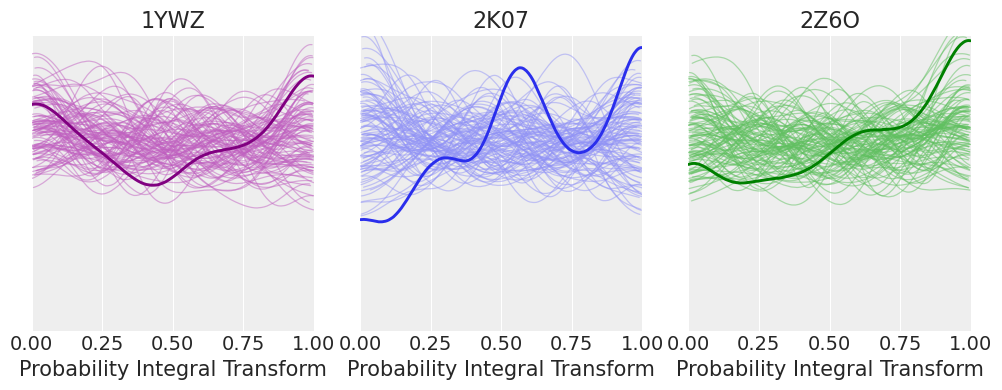

In [86]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_protein_1, y="cheshift", legend=False, ax=ax[0], color='purple')
az.plot_loo_pit(idata_protein_2, y="cheshift", legend=False, ax=ax[1])
az.plot_loo_pit(idata_protein_3, y="cheshift", legend=False, ax=ax[2], color='green')
ax[0].set_title(protein1)
ax[1].set_title(protein2)
ax[2].set_title(protein3)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_{protein3}_loo_pit.png", dpi=300)

# Khat

In [87]:
# compute LOO separately
loo_protein_1 = az.loo(idata_protein_1, pointwise=True)
loo_protein_2 = az.loo(idata_protein_2, pointwise=True)
loo_protein_3 = az.loo(idata_protein_3, pointwise=True)

<ipython-input-88-fc44805e9ee1>:37: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


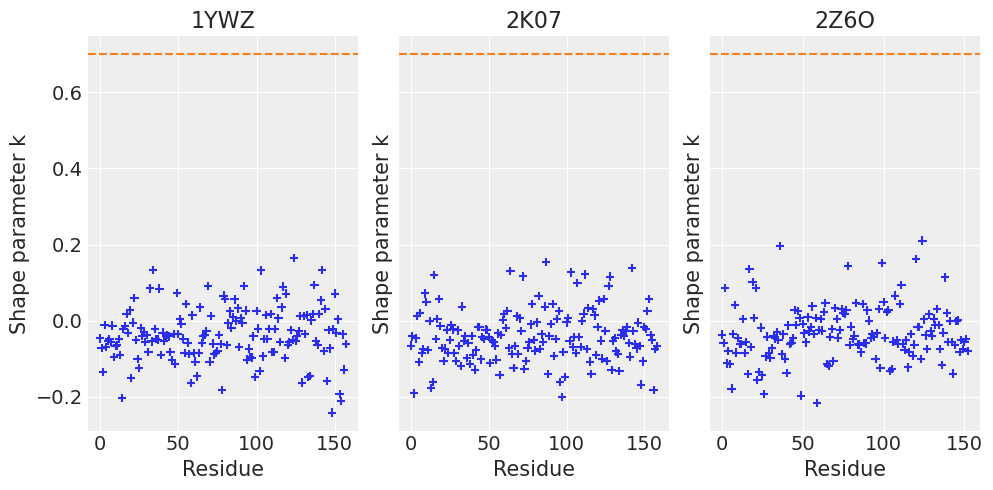

In [88]:
# Plot K-hat
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

az.plot_khat(loo_protein_1, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_protein_2, hlines_kwargs={"alpha":0}, ax=ax[1])
az.plot_khat(loo_protein_3, hlines_kwargs={"alpha":0}, ax=ax[2])

da = dataframe_protein_1.res[loo_protein_1.pareto_k.values > 0.7]
xs = da.index.values + 1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = loo_protein_1.pareto_k[loo_protein_1.pareto_k > 0.7].values

for tx, x, y in zip(text, xs, ys):
    ax[0].annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y))
    
da = dataframe_protein_2.res[loo_protein_2.pareto_k.values > 0.7]
xs = da.index.values +1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = loo_protein_2.pareto_k[loo_protein_2.pareto_k > 0.7].values

for tx, x, y in zip(text, xs, ys):
    ax[1].annotate(tx, (x + 0.5 - dataframe_protein_2.index[0], y))
    
da = dataframe_protein_3.res[loo_protein_3.pareto_k.values > 0.7]
xs = da.index.values +1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = loo_protein_3.pareto_k[loo_protein_3.pareto_k > 0.7].values

for tx, x, y in zip(text, xs, ys):
    ax[2].annotate(tx, (x + 0.5 - dataframe_protein_3.index[0], y))

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
[ax[i].set_title(protein) for i, protein in enumerate([protein1, protein2, protein3])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_{protein3}_khat.png", dpi=300)

# ELPD

In [89]:
# compute ELPD difference
loo_protein_1 = az.loo(idata_protein_1, pointwise=True).loo_i.values
loo_protein_2 = az.loo(idata_protein_2, pointwise=True).loo_i.values
loo_protein_3 = az.loo(idata_protein_3, pointwise=True).loo_i.values
loo_protein_1.shape, loo_protein_2.shape, loo_protein_3.shape

((158,), (159,), (153,))

In [90]:
dataframe_protein_1.tail() 

,protein,res,bmrb_code,ca_exp,ca_teo
160,1YWZ,HIS,6546,57.3,54.479000
161,1YWZ,LYS,6546,56.7,56.151500
162,1YWZ,GLU,6546,55.9,57.376500
163,1YWZ,LYS,6546,56.3,56.927500
165,1YWZ,ASN,6546,53.2,52.127333


In [91]:
dataframe_protein_2.tail()

,protein,res,bmrb_code,ca_exp,ca_teo
161,2K07,LYS,6546,56.7,54.8830
162,2K07,GLU,6546,55.9,57.1190
163,2K07,LYS,6546,56.3,55.8770
165,2K07,ASN,6546,53.2,52.6735
166,2K07,GLN,6546,56.0,54.9640


In [92]:
elpd = loo_protein_1 - loo_protein_2[:-1]

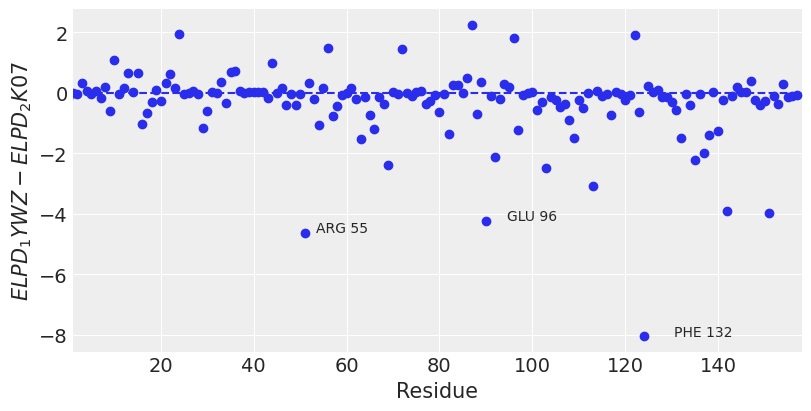

In [93]:
# plot ELPD difference
_, ax = plt.subplots(figsize=(8,4))
ax.scatter(range(dataframe_protein_1.shape[0]), elpd)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel(f'$ELPD_{protein1}-ELPD_{protein2}$')
ax.set_xlim(1, len(dataframe_protein_1))
# ax.set_xticks([-1, 8, 18, 28, 38, 48, 58, 68])
# ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70'])
ax.set_title('')
da_1 = dataframe_protein_1.res[elpd > 4]
da_2 = dataframe_protein_1.res[elpd < -4]
da = pd.concat([da_1, da_2])
xs = da.index.values+1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text, xs, ys):
    ax.annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight", dpi=300);

In [94]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = "1XO4"
protein2 = '2EVN'
protein3 = '1XMT' #crystal structure
bmrb_code = '6338'
samples = 2000

In [95]:
# CS data is collected for every protein in a single dataframe
dataframe_protein_1 = get_biomolecular_data(protein1, bmrb_code)
dataframe_protein_2 = get_biomolecular_data(protein2, bmrb_code)
dataframe_protein_3 = get_biomolecular_data(protein3, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)
/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)
/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [96]:
# run hierarchical bayesian linear regression for each protein 
if f'idata_{protein1}.nc' in os.listdir('./data/'):
    idata_protein_1 = az.from_netcdf(f'data/idata_{protein1}.nc')
else:
    dataframe_reference_protein_1, idata_reference_protein_1 = hierarchical_reg_reference(target_df=dataframe_protein_1, samples=2000)
    idata_protein_1 = idata_reference_protein_1.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_1.shape[0]-dataframe_protein_1.shape[0], dataframe_reference_protein_1.shape[0]))
    az.to_netcdf(idata_protein_1, f"data/idata_{protein1}.nc")

In [97]:
if f'idata_{protein2}.nc' in os.listdir('./data/'):
    idata_protein_2 = az.from_netcdf(f'data/idata_{protein2}.nc')
else:
    dataframe_reference_protein_2, idata_reference_protein_2 = hierarchical_reg_reference(target_df=dataframe_protein_2, samples=2000)
    idata_protein_2 = idata_reference_protein_2.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_2.shape[0]-dataframe_protein_2.shape[0], dataframe_reference_protein_2.shape[0]))
    az.to_netcdf(idata_protein_2, f"data/idata_{protein2}.nc")

In [98]:
if f'idata_{protein3}.nc' in os.listdir('./data/'):
    idata_protein_3 = az.from_netcdf(f'data/idata_{protein3}.nc')
else:
    dataframe_reference_protein_3, idata_reference_protein_3 = hierarchical_reg_reference(target_df=dataframe_protein_3, samples=2000)
    idata_protein_3 = idata_reference_protein_3.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_3.shape[0]-dataframe_protein_3.shape[0], dataframe_reference_protein_3.shape[0]))
    az.to_netcdf(idata_protein_3, f"data/idata_{protein3}.nc")

# LOO

<ipython-input-99-752a75692290>:11: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


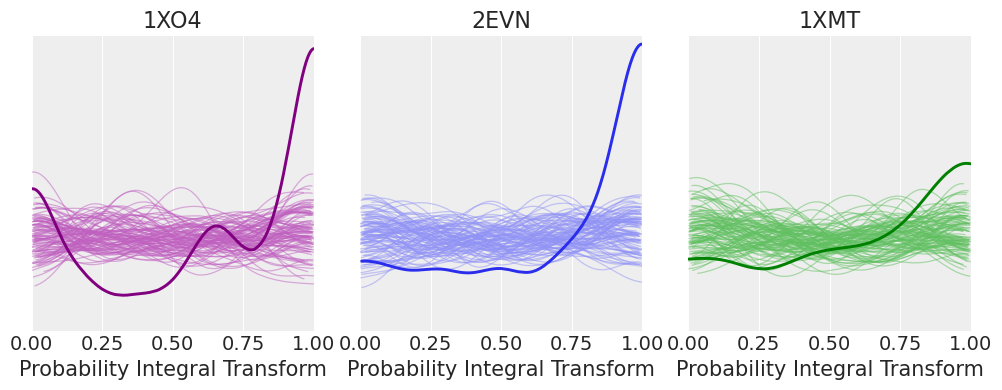

In [99]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_protein_1, y="cheshift", legend=False, ax=ax[0], color='purple')
az.plot_loo_pit(idata_protein_2, y="cheshift", legend=False, ax=ax[1])
az.plot_loo_pit(idata_protein_3, y="cheshift", legend=False, ax=ax[2], color='green')
ax[0].set_title(protein1)
ax[1].set_title(protein2)
ax[2].set_title(protein3)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_{protein3}_loo_pit.png", dpi=300)

# Khat

In [100]:
# compute LOO separately
loo_protein_1 = az.loo(idata_protein_1, pointwise=True)
loo_protein_2 = az.loo(idata_protein_2, pointwise=True)
loo_protein_3 = az.loo(idata_protein_3, pointwise=True)

<ipython-input-101-0d2f86313245>:13: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


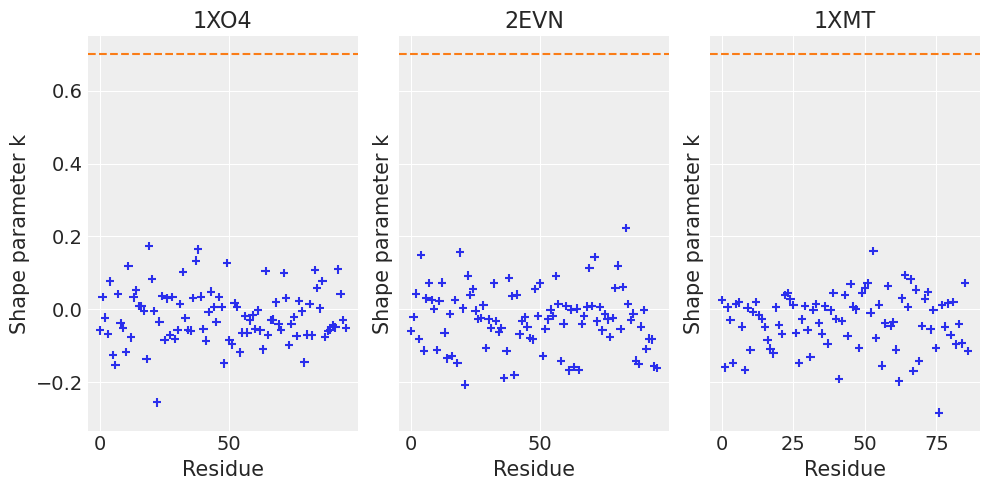

In [101]:
# Plot K-hat
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

az.plot_khat(loo_protein_1, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_protein_2, hlines_kwargs={"alpha":0}, ax=ax[1])
az.plot_khat(loo_protein_3, hlines_kwargs={"alpha":0}, ax=ax[2])

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
[ax[i].set_title(protein) for i, protein in enumerate([protein1, protein2, protein3])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_{protein3}_khat.png")

# ELPD

In [102]:
# compute ELPD difference
loo_protein_1 = az.loo(idata_protein_1, pointwise=True).loo_i.values
loo_protein_2 = az.loo(idata_protein_2, pointwise=True).loo_i.values
loo_protein_3 = az.loo(idata_protein_3, pointwise=True).loo_i.values
loo_protein_1.shape, loo_protein_2.shape, loo_protein_3.shape

((96,), (96,), (87,))

In [103]:
elpd = loo_protein_1 - loo_protein_2

/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/elpdplot.py:106: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.autofmt_xdate()


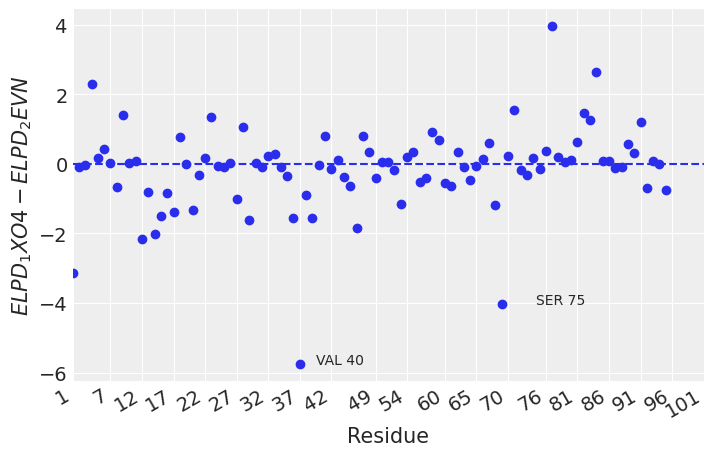

In [104]:
# plot ELPD difference
ax = az.plot_elpd({f"{protein1}": idata_protein_1, f"{protein2}": idata_protein_2}, xlabels=True)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel(f'$ELPD_{protein1}-ELPD_{protein2}$')
ax.set_xlim(1, len(dataframe_protein_1))
ax.set_xticks(dataframe_protein_1.index[::5])
ax.set_xticklabels([str(n) for n in dataframe_protein_1.index[::5]])

ax.set_title('')
da_1 = dataframe_protein_1.res[elpd > 4]
da_2 = dataframe_protein_1.res[elpd < -4]
da = pd.concat([da_1, da_2])
xs = da.index.values+1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text, xs, ys):
    ax.annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight", dpi=300);

In [105]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = "1D5K"
protein2 = '1GH8'
bmrb_code = '4385'
samples = 2000

In [106]:
# CS data is collected for every protein in a single dataframe
dataframe_protein_1 = get_biomolecular_data(protein1, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [107]:
dataframe_protein_2 = get_biomolecular_data(protein2, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [108]:
# run hierarchical bayesian linear regression for each protein 
if f'idata_{protein1}.nc' in os.listdir('./data/'):
    idata_protein_1 = az.from_netcdf(f'data/idata_{protein1}.nc')
else:
    dataframe_reference_protein_1, idata_reference_protein_1 = hierarchical_reg_reference(target_df=dataframe_protein_1, samples=2000)
    idata_protein_1 = idata_reference_protein_1.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_1.shape[0]-dataframe_protein_1.shape[0], dataframe_reference_protein_1.shape[0]))
    az.to_netcdf(idata_protein_1, f"data/idata_{protein1}.nc")

In [109]:
if f'idata_{protein2}.nc' in os.listdir('./data/'):
    idata_protein_2 = az.from_netcdf(f'data/idata_{protein2}.nc')
else:
    dataframe_reference_protein_2, idata_reference_protein_2 = hierarchical_reg_reference(target_df=dataframe_protein_2, samples=2000)
    idata_protein_2 = idata_reference_protein_2.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_2.shape[0]-dataframe_protein_2.shape[0], dataframe_reference_protein_2.shape[0]))
    az.to_netcdf(idata_protein_2, f"data/idata_{protein2}.nc")


# LOO

<ipython-input-110-1c49bb78bea1>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


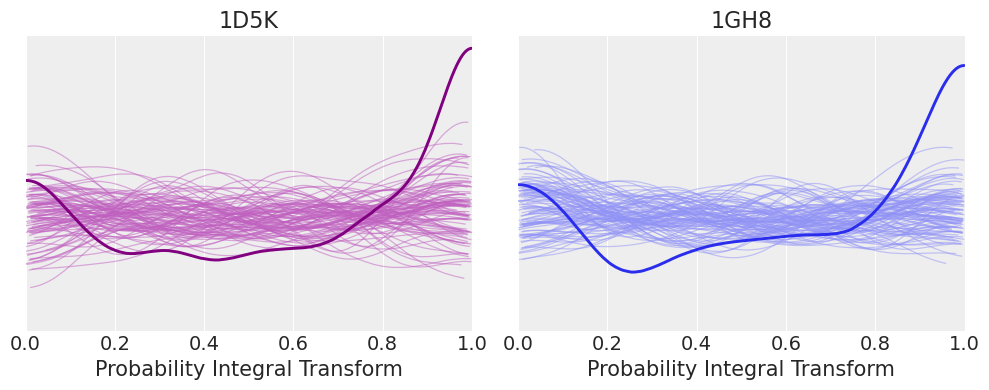

In [110]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_protein_1, y="cheshift", legend=False, ax=ax[0], color='purple')
az.plot_loo_pit(idata_protein_2, y="cheshift", legend=False, ax=ax[1])
ax[0].set_title(protein1)
ax[1].set_title(protein2)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_loo_pit.png", dpi=300)

# Khat

In [111]:
# compute LOO separately
loo_protein_1 = az.loo(idata_protein_1, pointwise=True)
loo_protein_2 = az.loo(idata_protein_2, pointwise=True)

/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<ipython-input-112-012246feac5c>:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


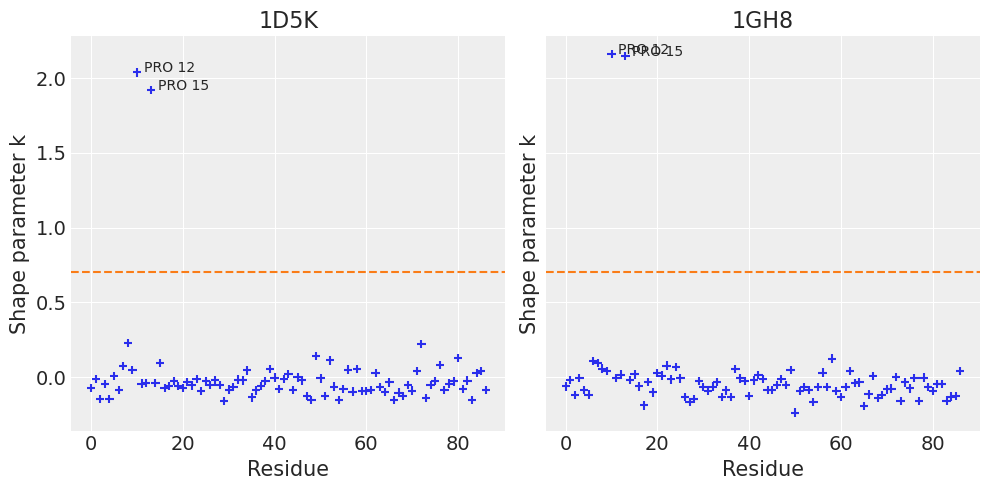

In [112]:
# Plot K-hat
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

az.plot_khat(loo_protein_1, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_protein_2, hlines_kwargs={"alpha":0}, ax=ax[1])

da = dataframe_protein_1.res[loo_protein_1.pareto_k.values > 0.7]
xs = da.index.values + 1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = loo_protein_1.pareto_k[loo_protein_1.pareto_k > 0.7].values

for tx, x, y in zip(text, xs, ys):
    ax[0].annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y))
    
da = dataframe_protein_2.res[loo_protein_2.pareto_k.values > 0.7]
xs = da.index.values +1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = loo_protein_2.pareto_k[loo_protein_2.pareto_k > 0.7].values

for tx, x, y in zip(text, xs, ys):
    ax[1].annotate(tx, (x + 0.5 - dataframe_protein_2.index[0], y))

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]

[ax[i].set_title(protein) for i, protein in enumerate([protein1, protein2])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_khat.png", dpi=300)

# ELPD

In [113]:
# compute ELPD difference
loo_protein_1 = az.loo(idata_protein_1, pointwise=True).loo_i.values
loo_protein_2 = az.loo(idata_protein_2, pointwise=True).loo_i.values
elpd = loo_protein_1 - loo_protein_2

/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/arroyuelo/anaconda3/envs/validation/lib/python3.8/site-packages/arviz/stats/stats.py:692: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/arroyuelo/anaconda3/en

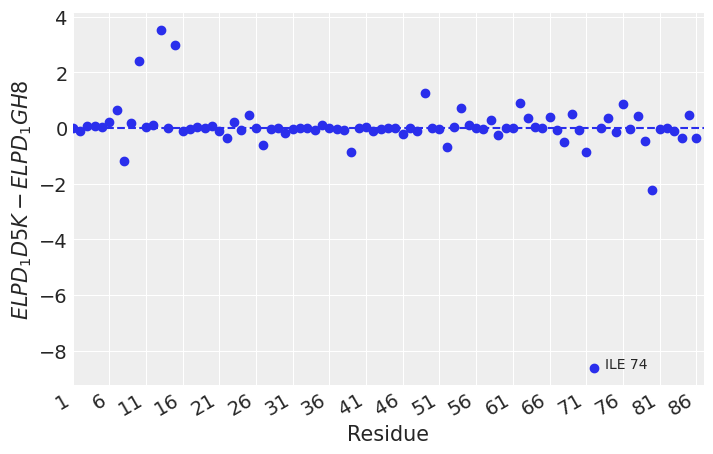

In [114]:
# plot ELPD difference
ax = az.plot_elpd({f"{protein1}": idata_protein_1, f"{protein2}": idata_protein_2}, xlabels=True)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel(f'$ELPD_{protein1}-ELPD_{protein2}$')
ax.set_xlim(1, len(dataframe_protein_1))
ax.set_xticks(dataframe_protein_1.index[::5])
ax.set_xticklabels([str(n) for n in dataframe_protein_1.index[::5]])
ax.set_title('')
da_1 = dataframe_protein_1.res[elpd > 4]
da_2 = dataframe_protein_1.res[elpd < -4]
da = pd.concat([da_1, da_2])
xs = da.index.values+1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text, xs, ys):
    ax.annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight", dpi=300);

In [115]:
# .pdb files for the structures to compare must be on the .\data folder along with the corresponding BMRB file
protein1 = '3MEF'
protein2 = '1MJC' #crystal structure
bmrb_code = '4296'
samples = 2000

In [147]:
# CS data is collected for every protein in a single dataframe
dataframe_protein_1 = get_biomolecular_data(protein1, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [148]:
dataframe_protein_2 = get_biomolecular_data(protein2, bmrb_code)

/home/arroyuelo/Hierarchical-Bayes-NMR-Validation/Hierarchical-Bayes-NMR-Validation-master_new/cheshift/_cheshift.py:635: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [118]:
# run hierarchical bayesian linear regression for each protein 
if f'idata_{protein1}.nc' in os.listdir('./data/'):
    idata_protein_1 = az.from_netcdf(f'data/idata_{protein1}.nc')
else:
    dataframe_reference_protein_1, idata_reference_protein_1 = hierarchical_reg_reference(target_df=dataframe_protein_1, samples=2000)
    idata_protein_1 = idata_reference_protein_1.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_1.shape[0]-dataframe_protein_1.shape[0], dataframe_reference_protein_1.shape[0]))
    az.to_netcdf(idata_protein_1, f"data/idata_{protein1}.nc")

In [119]:
if f'idata_{protein2}.nc' in os.listdir('./data/'):
    idata_protein_2 = az.from_netcdf(f'data/idata_{protein2}.nc')
else:
    dataframe_reference_protein_2, idata_reference_protein_2 = hierarchical_reg_reference(target_df=dataframe_protein_2, samples=2000)
    idata_protein_2 = idata_reference_protein_2.sel(
                                                    cheshift_dim_0=slice(dataframe_reference_protein_2.shape[0]-dataframe_protein_2.shape[0], dataframe_reference_protein_2.shape[0]))
    az.to_netcdf(idata_protein_2, f"data/idata_{protein2}.nc")

# LOO

<ipython-input-120-1c49bb78bea1>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


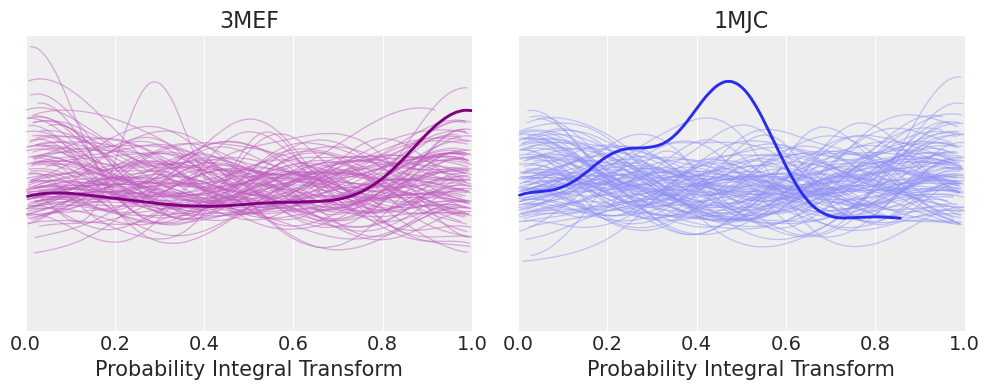

In [120]:
# Plot LOO-PIT
fig_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_protein_1, y="cheshift", legend=False, ax=ax[0], color='purple')
az.plot_loo_pit(idata_protein_2, y="cheshift", legend=False, ax=ax[1])
ax[0].set_title(protein1)
ax[1].set_title(protein2)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_loo_pit.png", dpi=300)

# Khat

In [121]:
# compute LOO separately
loo_protein_1 = az.loo(idata_protein_1, pointwise=True)
loo_protein_2 = az.loo(idata_protein_2, pointwise=True)

<ipython-input-122-c8d8fc6a384c>:31: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


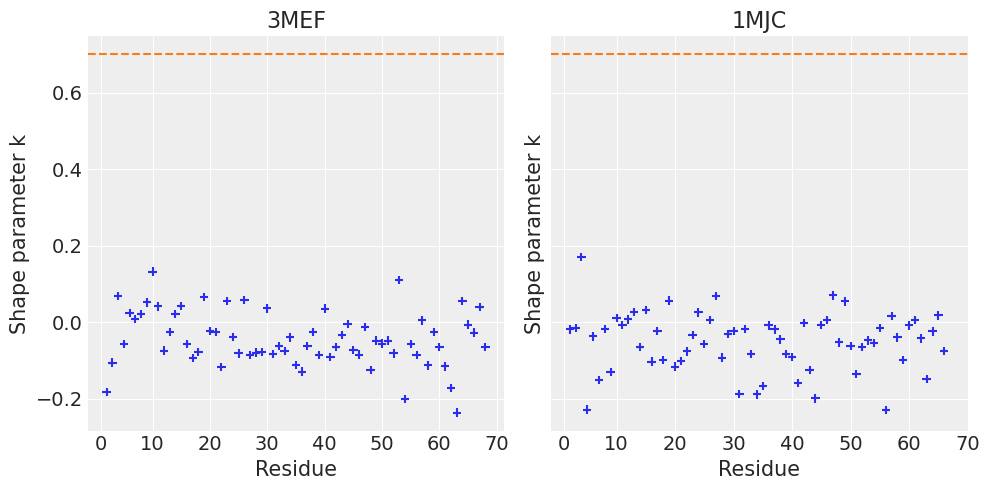

In [122]:
# Plot K-hat
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

az.plot_khat(loo_protein_1, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_protein_2, hlines_kwargs={"alpha":0}, ax=ax[1])

da = dataframe_protein_1.res[loo_protein_1.pareto_k.values > 0.7]
xs = da.index.values + 1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = loo_protein_1.pareto_k[loo_protein_1.pareto_k > 0.7].values

for tx, x, y in zip(text, xs, ys):
    ax[0].annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y))
    
da = dataframe_protein_2.res[loo_protein_2.pareto_k.values > 0.7]
xs = da.index.values +1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = loo_protein_2.pareto_k[loo_protein_2.pareto_k > 0.7].values

for tx, x, y in zip(text, xs, ys):
    ax[1].annotate(tx, (x + 0.5 - dataframe_protein_2.index[0], y))

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
[ax[i].set_xticks([-1, 8, 18, 28, 38, 48, 58, 68]) for i in range(len(ax))]
[ax[i].set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70']) for i in range(len(ax))]

[ax[i].set_title(protein) for i, protein in enumerate([protein1, protein2])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_khat.png", dpi=300)

# ELPD

In [123]:
# compute ELPD difference
loo_protein_1 = az.loo(idata_protein_1, pointwise=True).loo_i.values
loo_protein_2 = az.loo(idata_protein_2, pointwise=True).loo_i.values
loo_protein_1.shape, loo_protein_2.shape

((67,), (65,))

In [144]:
loo_protein_1 = np.delete(np.array(loo_protein_1), [10, 36])

In [150]:
dataframe_protein_1.drop([10, 36], inplace=True)

In [145]:
elpd = loo_protein_1 - loo_protein_2

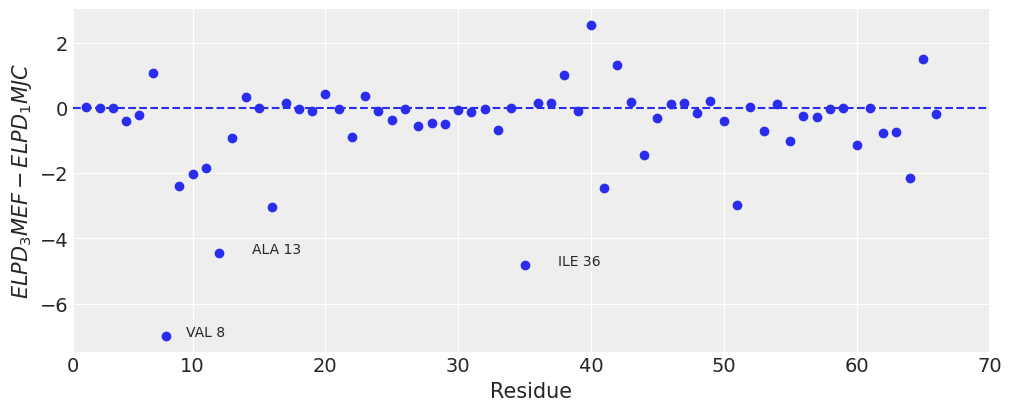

In [151]:
# plot ELPD difference
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(range(len(elpd)), elpd)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel(f'$ELPD_{protein1}-ELPD_{protein2}$')
ax.set_xlim(1, len(dataframe_protein_1))
ax.set_xticks([-1, 8, 18, 28, 38, 48, 58, 68])
ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70'])
ax.set_title('')
da_1 = dataframe_protein_1.res[elpd > 4]
da_2 = dataframe_protein_1.res[elpd < -4]
da = pd.concat([da_1, da_2])
xs = da.index.values+1
text = [a + " " + str(b) for a, b in zip(da, xs)]
ys = np.concatenate([elpd[elpd > 4], elpd[elpd < -4]])

for tx, x, y in zip(text, xs, ys):
    ax.annotate(tx, (x + 0.5 - dataframe_protein_1.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight");

In [ ]:
%watermark -v -m -p numpy,matplotlib,pymc3,arviz